Questions to the dataset:
1. What's the distribution of Serious , slight and all accidents in relation to the day of the Week.
2. Motorcycle accidents
3. 

In [33]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
spark = SparkSession \
    .builder \
    .appName("Bundesliga") \
    .getOrCreate()

In [41]:
def load_dataframe(filename):
    df=spark.read.format('csv').options(header='true').load(filename)
    return df

df_accidents = load_dataframe('./data/car_accidents/Accident_information.csv')
df_accidents.limit(5).show()

+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+----------+-----------+-------------------------------------------+--------------------+--------------------+---------+--------------------+--------------------------+-------------------------+---------------------+----------------------+---------+-------------------------+--------------------+------------------+---------------------------------+---------------------------------------+-------------------+-----------------------+------------------+--------------------------+-----------+-----+-------------------+--------------------+----+----------+
|Accident_Index|1st_Road_Class|1st_Road_Number|2nd_Road_Class|2nd_Road_Number|Accident_Severity|Carriageway_Hazards|      Date|Day_of_Week|Did_Police_Officer_Attend_Scene_of_Accident|    Junction_Control|     Junction_Detail| Latitude|    Light_Conditions|Local_Authority_(District)|Local_Authority_(Highway)|Location_Easting_OSGR

In [55]:
df_accidents

['Accident_Index',
 '1st_Road_Class',
 '1st_Road_Number',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Accident_Severity',
 'Carriageway_Hazards',
 'Date',
 'Day_of_Week',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Junction_Control',
 'Junction_Detail',
 'Latitude',
 'Light_Conditions',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'LSOA_of_Accident_Location',
 'Number_of_Casualties',
 'Number_of_Vehicles',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Police_Force',
 'Road_Surface_Conditions',
 'Road_Type',
 'Special_Conditions_at_Site',
 'Speed_limit',
 'Time',
 'Urban_or_Rural_Area',
 'Weather_Conditions',
 'Year',
 'InScotland']

### What's the distribution of Serious, Slight and all accidents in relation to the day of the Week.

In [64]:
#checking the distinct values of the Accident Severity column
df_accidents.select('Accident_Severity').distinct().collect()

[Row(Accident_Severity='Slight'),
 Row(Accident_Severity='Fatal'),
 Row(Accident_Severity='Serious')]

In [63]:
#checking Null values
null_count = df_accidents.filter(col('Accident_Severity').isNull()).count()
null_count

0

In [65]:
accidents = df_accidents \
    .withColumn('Slight', when(col('Accident_Severity') == 'Slight', 1).otherwise(0)) \
    .withColumn('Fatal', when(col('Accident_Severity') == 'Fatal', 1).otherwise(0)) \
    .withColumn('Serious', when(col('Accident_Severity') == 'Serious', 1).otherwise(0)) \



In [68]:
accidents.columns

['Accident_Index',
 '1st_Road_Class',
 '1st_Road_Number',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Accident_Severity',
 'Carriageway_Hazards',
 'Date',
 'Day_of_Week',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Junction_Control',
 'Junction_Detail',
 'Latitude',
 'Light_Conditions',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'LSOA_of_Accident_Location',
 'Number_of_Casualties',
 'Number_of_Vehicles',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Police_Force',
 'Road_Surface_Conditions',
 'Road_Type',
 'Special_Conditions_at_Site',
 'Speed_limit',
 'Time',
 'Urban_or_Rural_Area',
 'Weather_Conditions',
 'Year',
 'InScotland',
 'Slight',
 'Fatal',
 'Serious']

In [97]:
all = accidents.groupby('Day_of_Week') \
    .agg(count('Accident_Severity').alias('Count of accidents (All Types)'), \
         sum('Slight').alias('Count of slight accidents'), \
         sum('Serious').alias('Count of Serious accidents'), \
         sum('Fatal').alias('Count of Fatal accidents'))

In [74]:
all.show()

+-----------+------------------------------+-------------------------+--------------------------+------------------------+
|Day_of_Week|Count of accidents (All Types)|Count of slight accidents|Count of Serious accidents|Count of Fatal accidents|
+-----------+------------------------------+-------------------------+--------------------------+------------------------+
|  Wednesday|                        308580|                   264532|                     40683|                    3365|
|    Tuesday|                        306292|                   262430|                     40503|                    3359|
|     Friday|                        335183|                   285272|                     45877|                    4034|
|   Thursday|                        308240|                   263357|                     41376|                    3507|
|   Saturday|                        273152|                   226648|                     41986|                    4518|
|     Monday|   

In [107]:
all_df = all.toPandas()

weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

all_df['Day_of_Week_Num'] = all_df['Day_of_Week'].map(weekday_mapping)
df_sorted = all_df.sort_values(by='Day_of_Week_Num')
df_sorted

,Day_of_Week,Count of accidents (All Types),Count of slight accidents,Count of Serious accidents,Count of Fatal accidents,Day_of_Week_Num
5,Monday,290482,248516,38588,3378,0
1,Tuesday,306292,262430,40503,3359,1
0,Wednesday,308580,264532,40683,3365,2
3,Thursday,308240,263357,41376,3507,3
2,Friday,335183,285272,45877,4034,4
4,Saturday,273152,226648,41986,4518,5
6,Sunday,225327,183793,37326,4208,6


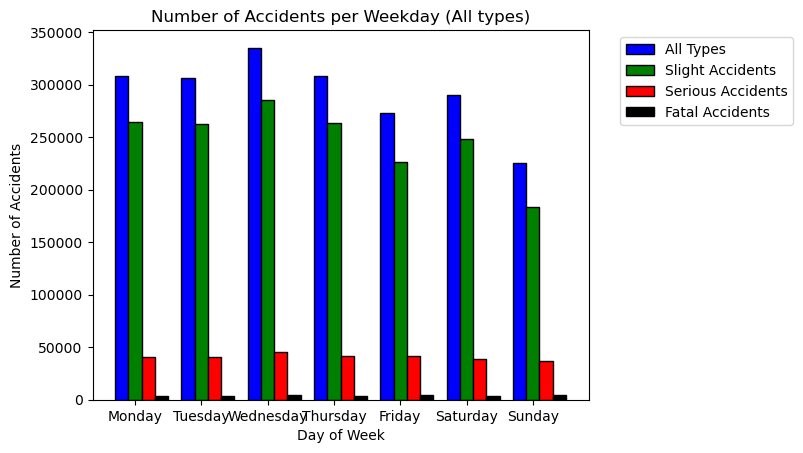

<Figure size 1500x600 with 0 Axes>

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
r = np.arange(7)
width = 0.2

# Adjusting x-coordinates for the bars
x1 = r - width
x2 = r
x3 = r + width
x4 = r + 2*width

# Plotting the bars
plt.bar(x1, all_df['Count of accidents (All Types)'], color='b', width=width, edgecolor='black', label='All Types')
plt.bar(x2, all_df['Count of slight accidents'], color='g', width=width, edgecolor='black', label='Slight Accidents')
plt.bar(x3, all_df['Count of Serious accidents'], color='r', width=width, edgecolor='black', label='Serious Accidents')
plt.bar(x4, all_df['Count of Fatal accidents'], color='black', width=width, edgecolor='black', label='Fatal Accidents')

# Adding labels and title
plt.xlabel("Day of Week") 
plt.ylabel("Number of Accidents") 
plt.title("Number of Accidents per Weekday (All types)") 

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(r, days_of_week)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.figure(figsize=(15,6))
plt.tight_layout()
plt.show()